## ECoG Movement decoding example 

This example notebook read openly accessible data from the publication *Electrocorticography is superior to subthalamic local field potentials for movement decoding in Parkinson’s disease* ([Merk et al. 2022](https://elifesciences.org/articles/75126)). The dataset is available [here](https://doi.org/10.7910/DVN/IO2FLM).

For simplicity one example subject is automatically shipped within this repo at the *examples/data* folder, stored in [iEEG BIDS](https://www.nature.com/articles/s41597-019-0105-7) format.


In [92]:
import py_neuromodulation as nm
from py_neuromodulation import (
    nm_analysis,
    nm_decode,
    nm_define_nmchannels,
    nm_IO,
    nm_plots,
    nm_settings,
    nm_stats
)
from sklearn import (
    metrics,
    model_selection,
)

import xgboost
import matplotlib.pyplot as plt
import numpy as np
import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's read the example using [mne_bids](https://mne.tools/mne-bids/stable/index.html). The resulting raw object in of type [mne.RawArray](https://mne.tools/stable/generated/mne.io.RawArray.html). We can use the properties such as sampling frequency, channel names, channel types all from the mne array and create the *nm_channels* dataframe:

In [48]:
RUN_NAME, PATH_RUN, PATH_BIDS, PATH_OUT, datatype = nm_IO.get_paths_example_data()

(
    raw,
    data,
    sfreq,
    line_noise,
    coord_list,
    coord_names,
) = nm_IO.read_BIDS_data(
    PATH_RUN=PATH_RUN, BIDS_PATH=PATH_BIDS, datatype=datatype
)

nm_channels = nm_define_nmchannels.set_channels(
    ch_names=raw.ch_names,
    ch_types=raw.get_channel_types(),
    reference="default",
    bads=raw.info["bads"],
    new_names="default",
    used_types=("ecog", "dbs", "seeg"),
    target_keywords=["MOV_RIGHT_CLEAN","MOV_LEFT_CLEAN"]
)

nm_channels

Extracting parameters from C:\code\py_neuromodulation\examples\data\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-3_ieeg.vhdr...
Setting channel info structure...
Reading channel info from C:\code\py_neuromodulation\examples\data\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-3_channels.tsv.
Reading electrode coords from C:\code\py_neuromodulation\examples\data\sub-000\ses-right\ieeg\sub-000_ses-right_space-mni_electrodes.tsv.


,name,rereference,used,target,type,status,new_name
0,LFP_RIGHT_0,LFP_RIGHT_2,1,0,seeg,good,LFP_RIGHT_0-LFP_RIGHT_2
1,LFP_RIGHT_1,LFP_RIGHT_0,1,0,seeg,good,LFP_RIGHT_1-LFP_RIGHT_0
2,LFP_RIGHT_2,LFP_RIGHT_1,1,0,seeg,good,LFP_RIGHT_2-LFP_RIGHT_1
3,ECOG_RIGHT_0,average,1,0,ecog,good,ECOG_RIGHT_0-avgref
4,ECOG_RIGHT_1,average,1,0,ecog,good,ECOG_RIGHT_1-avgref
5,ECOG_RIGHT_2,average,1,0,ecog,good,ECOG_RIGHT_2-avgref
6,ECOG_RIGHT_3,average,1,0,ecog,good,ECOG_RIGHT_3-avgref
7,ECOG_RIGHT_4,average,1,0,ecog,good,ECOG_RIGHT_4-avgref
8,ECOG_RIGHT_5,average,1,0,ecog,good,ECOG_RIGHT_5-avgref
9,MOV_RIGHT,None,0,0,misc,good,MOV_RIGHT


This example contains the force grip movement traces, we'll use the *MOV_RIGHT_CLEAN* channel as a decoding target channel. Let's check some of the raw feature and time series traces:

(0.0, 20.0)

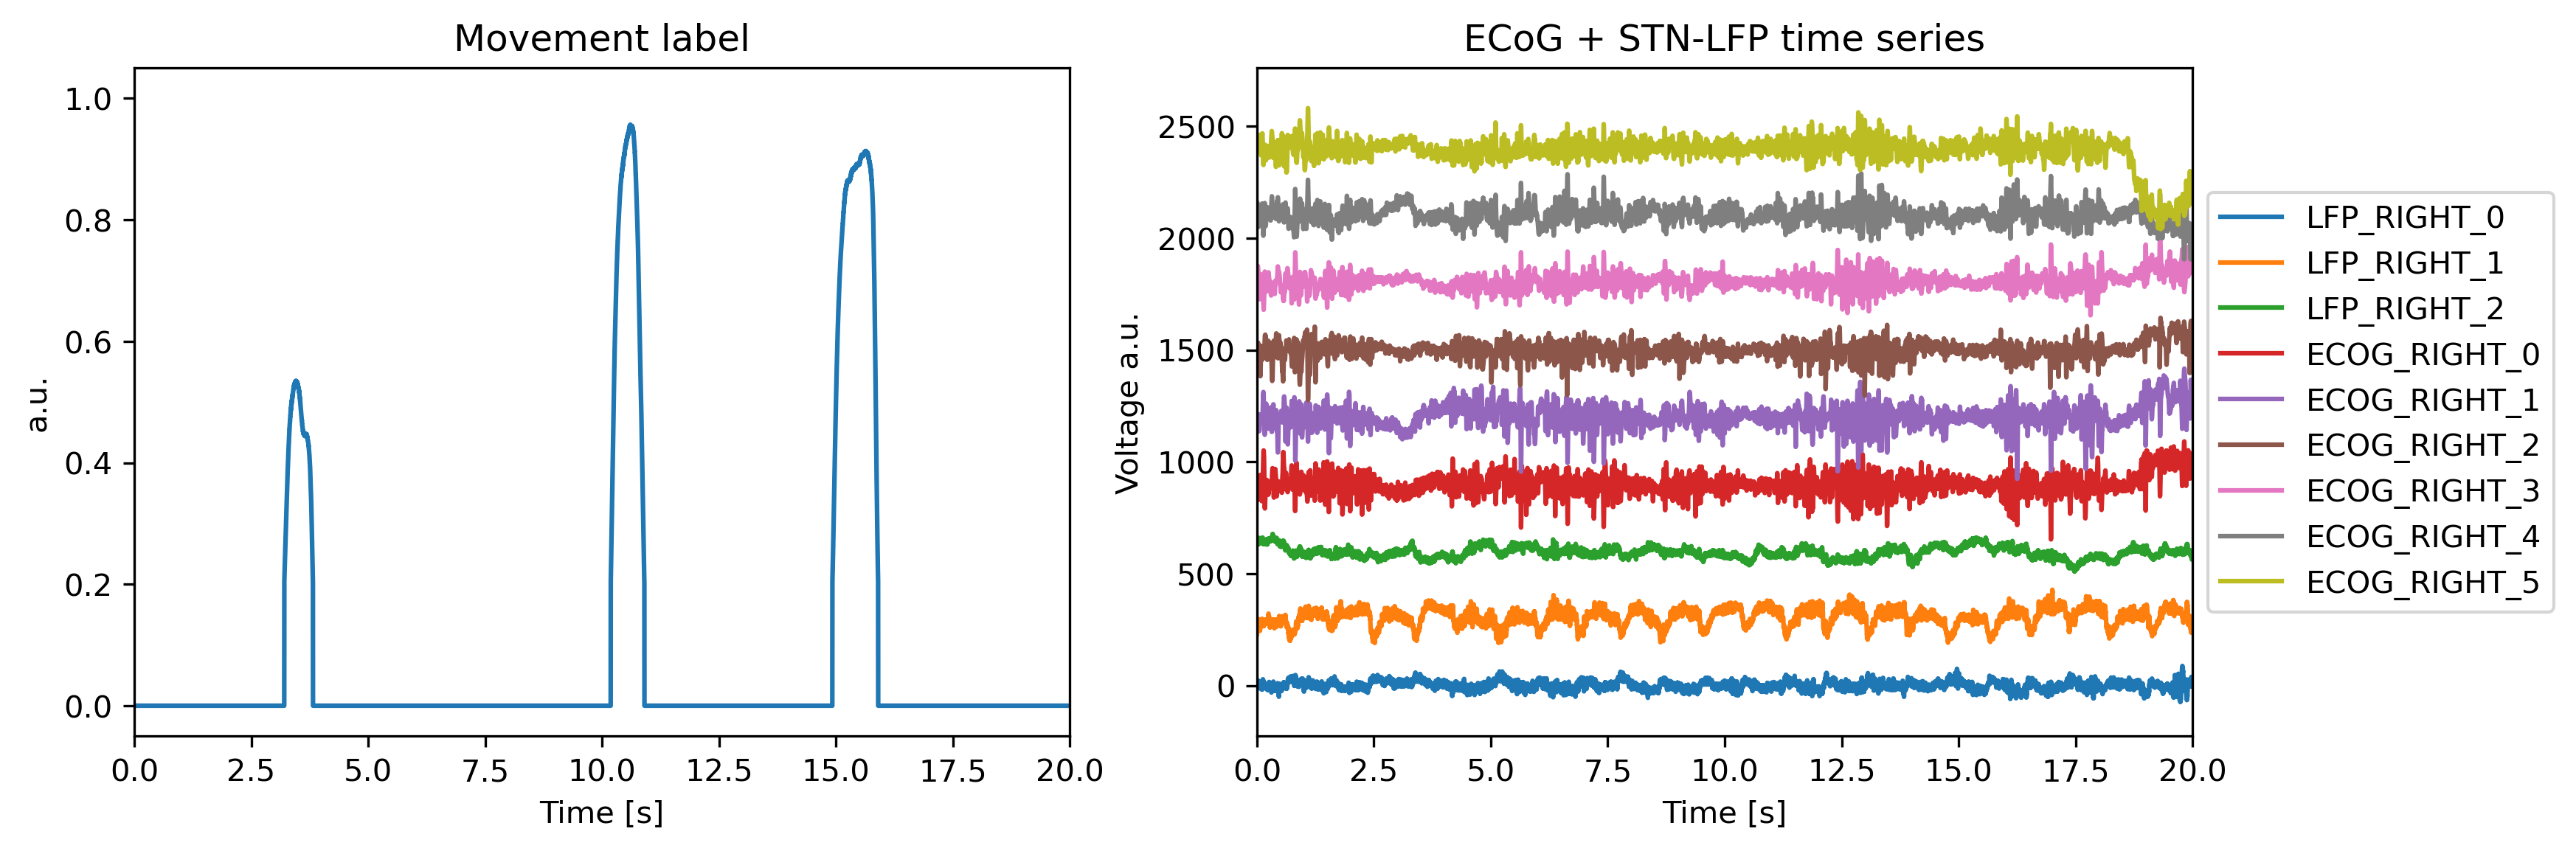

In [3]:
plt.figure(figsize=(12, 4), dpi=300)
plt.subplot(121)
plt.plot(raw.times, data[-2, :])
plt.xlabel("Time [s]")
plt.ylabel("a.u.")
plt.title("Movement label")
plt.xlim(0, 20)

plt.subplot(122)
for idx, ch_name in enumerate(nm_channels.query("used == 1").name):
    plt.plot(raw.times, data[idx, :] + idx*300, label=ch_name)
plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')
plt.title("ECoG + STN-LFP time series")
plt.xlabel("Time [s]")
plt.ylabel("Voltage a.u.")
plt.xlim(0, 20)

In [49]:
settings = nm_settings.get_default_settings()
settings = nm_settings.set_settings_fast_compute(settings)

settings["features"]["fft"] = True
settings["features"]["bursts"] = True
settings["features"]["sharpwave_analysis"] = True
settings["features"]["coherence"] = True
settings["coherence"]["channels"] = [
    [
        "LFP_RIGHT_0",
        "ECOG_RIGHT_0"
    ]
]
settings["coherence"]["frequency_bands"] = [
    "high beta",
    "low gamma"
]
settings["sharpwave_analysis_settings"]["estimator"]["mean"] = []
for sw_feature in list(
    settings["sharpwave_analysis_settings"]["sharpwave_features"].keys()
):
    settings["sharpwave_analysis_settings"]["sharpwave_features"][sw_feature] = True
    settings["sharpwave_analysis_settings"]["estimator"]["mean"].append(sw_feature)


In [103]:
stream = nm.Stream(
    sfreq=sfreq,
    nm_channels=nm_channels,
    settings=settings,
    line_noise=line_noise,
    coord_list=coord_list,
    coord_names=coord_names,
    verbose=False,
)


No data specified. Sanity checks related to the length of the signal relative to the filter order will be skipped.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 7.50 Hz
- Upper transition bandwidth: 7.50 Hz
- Filter length: 999 samples (0.999 sec)



In [104]:
stream.run(
    data=data[:, :int(sfreq*60)],
    out_path_root=PATH_OUT,
    folder_name=RUN_NAME,
)

_SIDECAR.json saved to C:\code\py_neuromodulation\examples\data\derivatives\sub-000_ses-right_task-force_run-3\sub-000_ses-right_task-force_run-3_SIDECAR.json
FEATURES.csv saved to C:\code\py_neuromodulation\examples\data\derivatives\sub-000_ses-right_task-force_run-3\sub-000_ses-right_task-force_run-3_FEATURES.csv
settings.json saved to C:\code\py_neuromodulation\examples\data\derivatives\sub-000_ses-right_task-force_run-3\sub-000_ses-right_task-force_run-3_SETTINGS.json
nm_channels.csv saved to C:\code\py_neuromodulation\examples\data\derivatives\sub-000_ses-right_task-force_run-3\sub-000_ses-right_task-force_run-3_nm_channels.csv


### Featue Analysis

The obtained performances can now be read and visualized using the *nm_analysis.Featuer_Reader*.

In [58]:
# init analyzer
feature_reader = nm_analysis.Feature_Reader(
    feature_dir=PATH_OUT, feature_file=RUN_NAME,
)
feature_reader.label_name = "MOV_LEFT_CLEAN"
feature_reader.label = feature_reader.feature_arr["MOV_LEFT_CLEAN"]

In [55]:
feature_reader.feature_arr

,LFP_RIGHT_0-LFP_RIGHT_2_fft_theta,LFP_RIGHT_0-LFP_RIGHT_2_fft_alpha,LFP_RIGHT_0-LFP_RIGHT_2_fft_low beta,LFP_RIGHT_0-LFP_RIGHT_2_fft_high beta,LFP_RIGHT_0-LFP_RIGHT_2_fft_low gamma,LFP_RIGHT_0-LFP_RIGHT_2_fft_high gamma,LFP_RIGHT_0-LFP_RIGHT_2_fft_HFA,LFP_RIGHT_1-LFP_RIGHT_0_fft_theta,LFP_RIGHT_1-LFP_RIGHT_0_fft_alpha,LFP_RIGHT_1-LFP_RIGHT_0_fft_low beta,...,ECOG_RIGHT_5-avgref_bursts_high beta_in_burst,ECOG_RIGHT_5-avgref_bursts_low gamma_duration_mean,ECOG_RIGHT_5-avgref_bursts_low gamma_amplitude_mean,ECOG_RIGHT_5-avgref_bursts_low gamma_duration_max,ECOG_RIGHT_5-avgref_bursts_low gamma_amplitude_max,ECOG_RIGHT_5-avgref_bursts_low gamma_burst_rate_per_s,ECOG_RIGHT_5-avgref_bursts_low gamma_in_burst,time,MOV_RIGHT_CLEAN,MOV_LEFT_CLEAN
0,8.199311,7.715267,7.307778,6.728352,5.408971,5.284942,4.574840,8.076921,7.667047,7.681364,...,0.000000,0.004386,1.681545,0.006000,4.148742,0.004386,1.000000,1000.0,0.0,0.0
1,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1100.0,0.0,0.0
2,-0.748604,-1.241930,-0.103458,1.132848,0.923839,0.672300,0.276416,-0.475502,-0.012554,-0.192267,...,0.000000,0.707107,0.417278,0.707107,-0.385417,0.707107,-0.707107,1200.0,0.0,0.0
3,0.203481,-1.381020,1.326449,0.008449,0.315458,-0.027865,0.522538,-0.226624,1.453535,1.097820,...,0.000000,-0.384657,0.526619,-1.000000,-0.531428,-0.384657,-0.577350,1300.0,0.0,0.0
4,-0.687114,-0.590184,-0.597682,0.084082,0.792506,-1.059643,0.254623,-0.083136,1.841833,0.838739,...,2.000000,1.234998,0.658157,0.816497,-0.163798,1.234998,-0.500000,1400.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,0.375886,-0.152099,-1.118822,-1.099174,-1.264676,-0.763392,0.576613,-0.008312,-0.111578,0.041051,...,2.263283,-0.503902,-0.594339,-0.746220,-0.594637,-0.503902,1.847096,59500.0,0.0,0.0
586,-0.336085,-0.465243,-1.544712,-0.838877,-0.191014,-0.697764,1.136398,-0.557561,-0.377499,0.011427,...,-0.441836,0.002852,-0.218895,1.234895,0.101910,0.002852,-0.536240,59600.0,0.0,0.0
587,1.809830,1.932354,-0.607973,-1.463207,-0.010697,-0.538885,2.061048,2.244167,1.779154,0.537435,...,-0.441836,0.383338,0.046809,1.226341,0.842206,0.383338,-0.536240,59700.0,0.0,0.0
588,0.706669,0.450661,-1.383534,-1.780110,0.085445,-1.205708,0.566786,0.082528,-0.851844,-0.202680,...,-0.441836,-0.502011,-0.632479,-0.751628,-0.600398,-0.502011,-0.536240,59800.0,0.0,0.0


In [59]:
feature_reader._get_target_ch()

'MOV_RIGHT_CLEAN'

Feature epoch average figure saved to: C:\code\py_neuromodulation\examples\data\derivatives\sub-000_ses-right_task-force_run-3\MOV_aligned_features_ch_ECOG_RIGHT_0_all.png


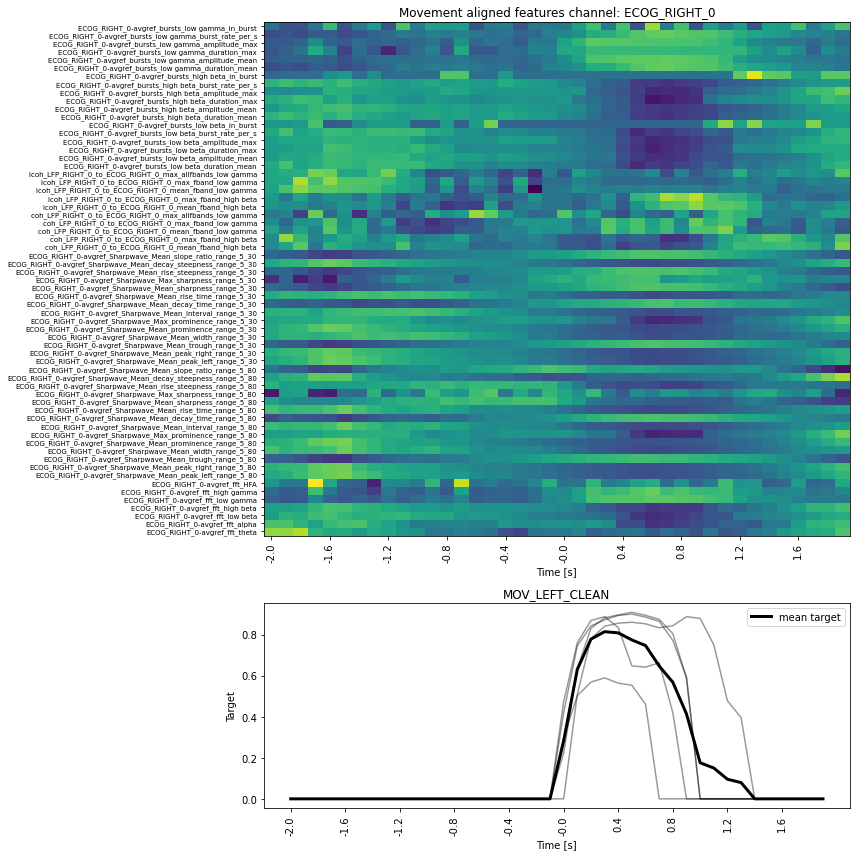

In [60]:
feature_reader.plot_target_averaged_channel(
    ch="ECOG_RIGHT_0",
    list_feature_keywords=None,
    epoch_len=4,
    threshold=0.5,
    ytick_labelsize=7,
    figsize_x=12,
    figsize_y=12
)

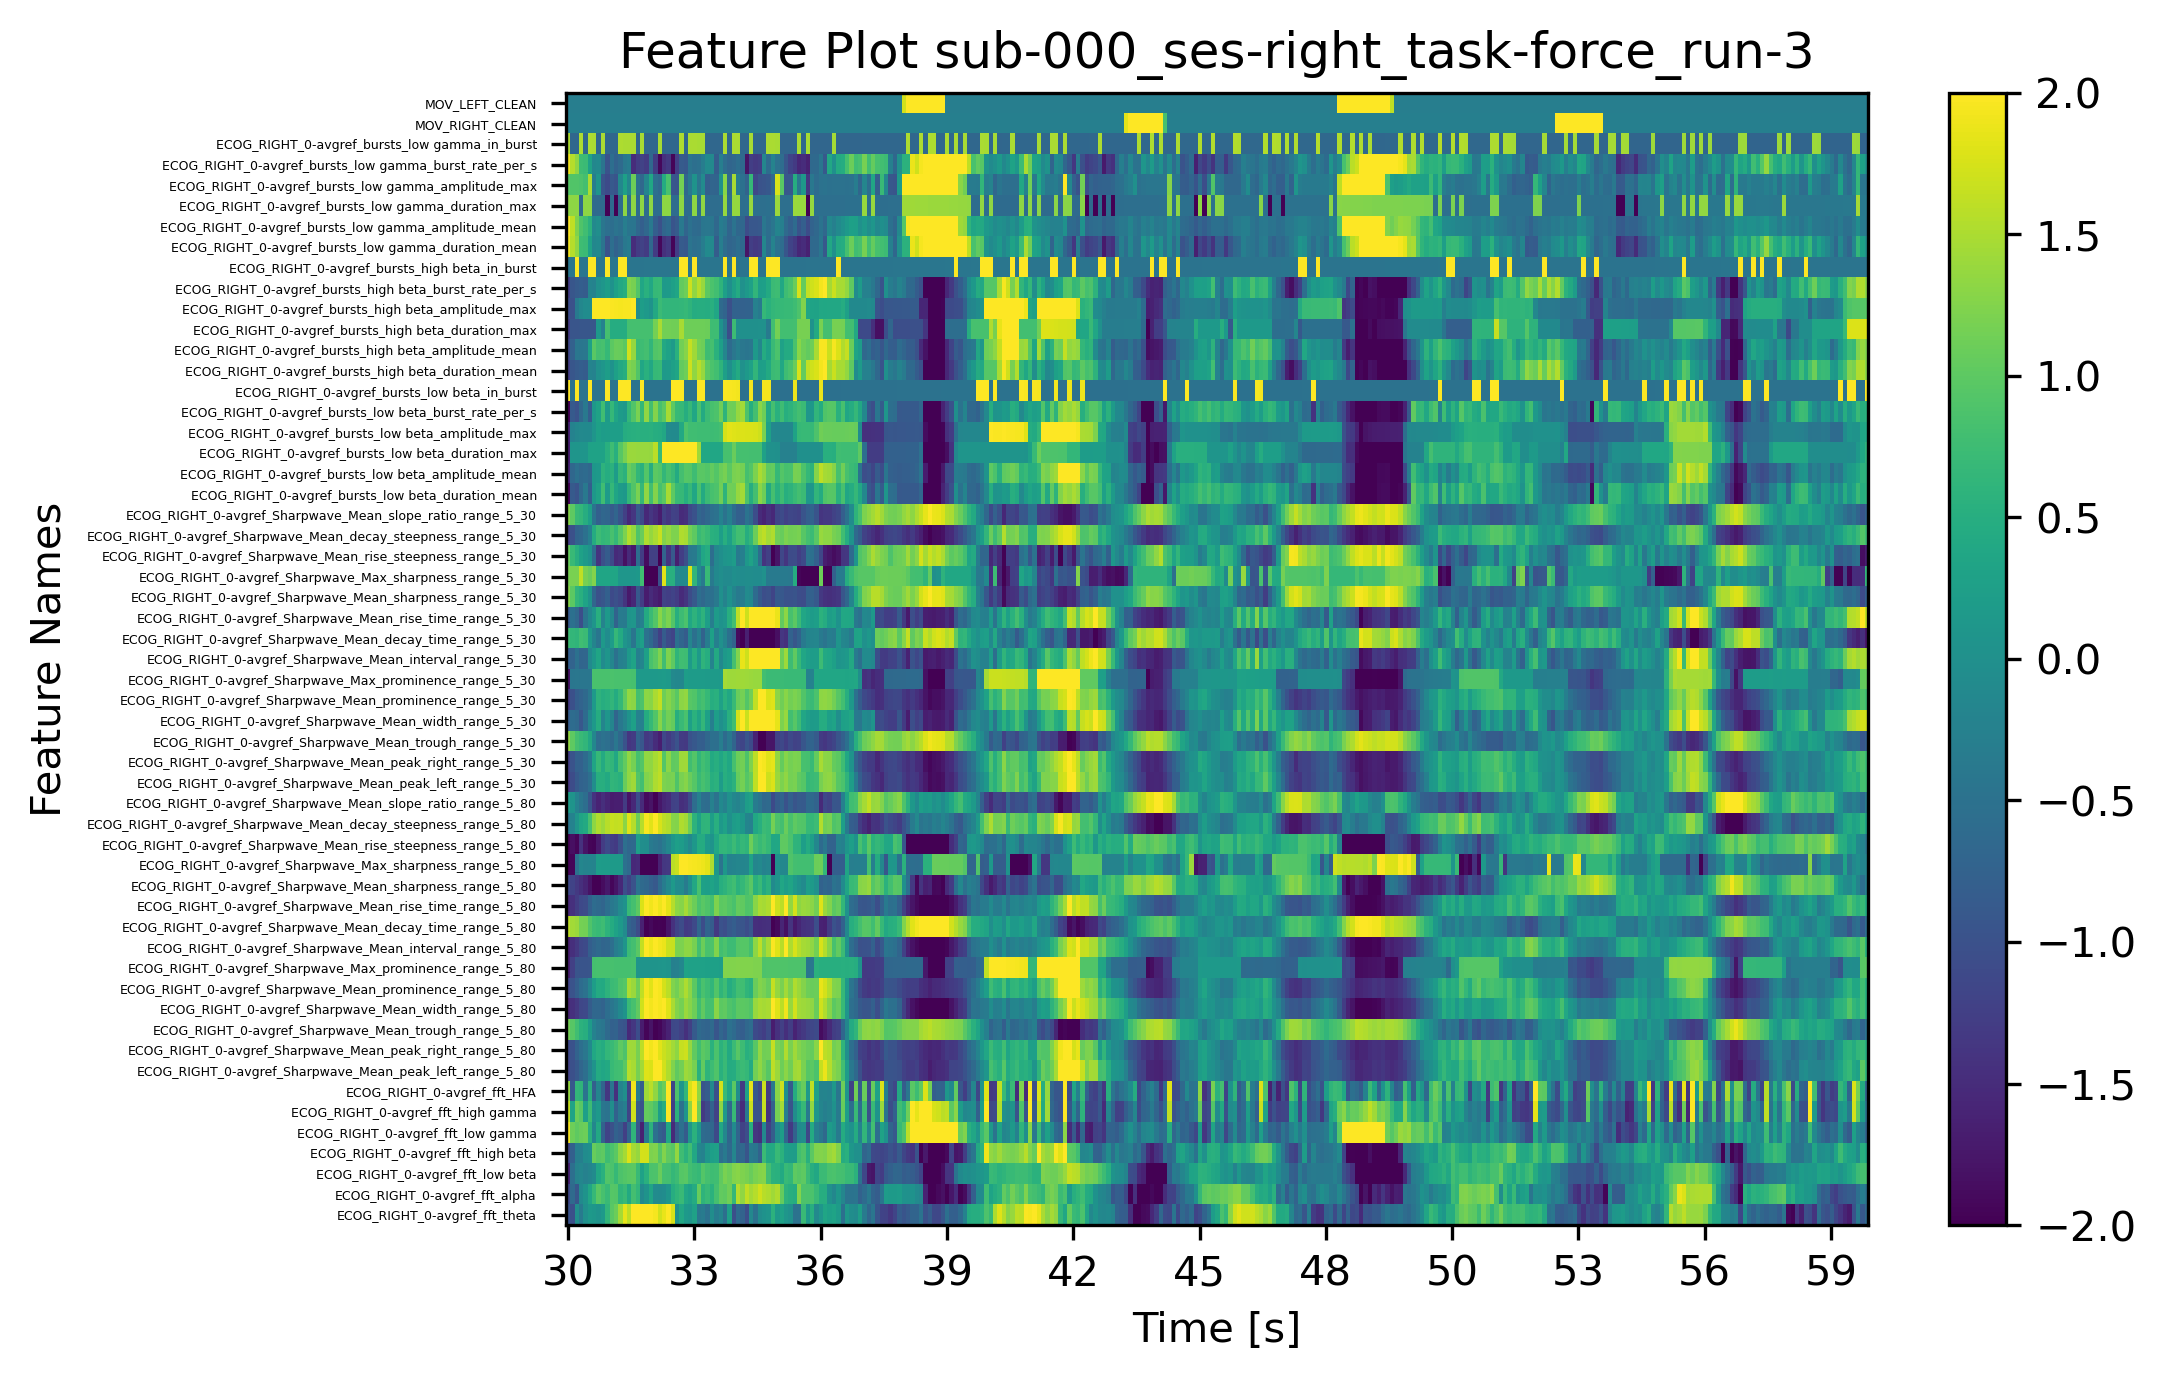

In [61]:
feature_reader.plot_all_features(
    ytick_labelsize=3,
    clim_low=-2,
    clim_high=2,
    ch_used="ECOG_RIGHT_0",
    time_limit_low_s=30,
    time_limit_high_s=60,
    normalize=True,
    save=True,
)

<AxesSubplot:title={'center':'Correlation matrix features channel: ECOG_RIGHT_0-avgref'}>

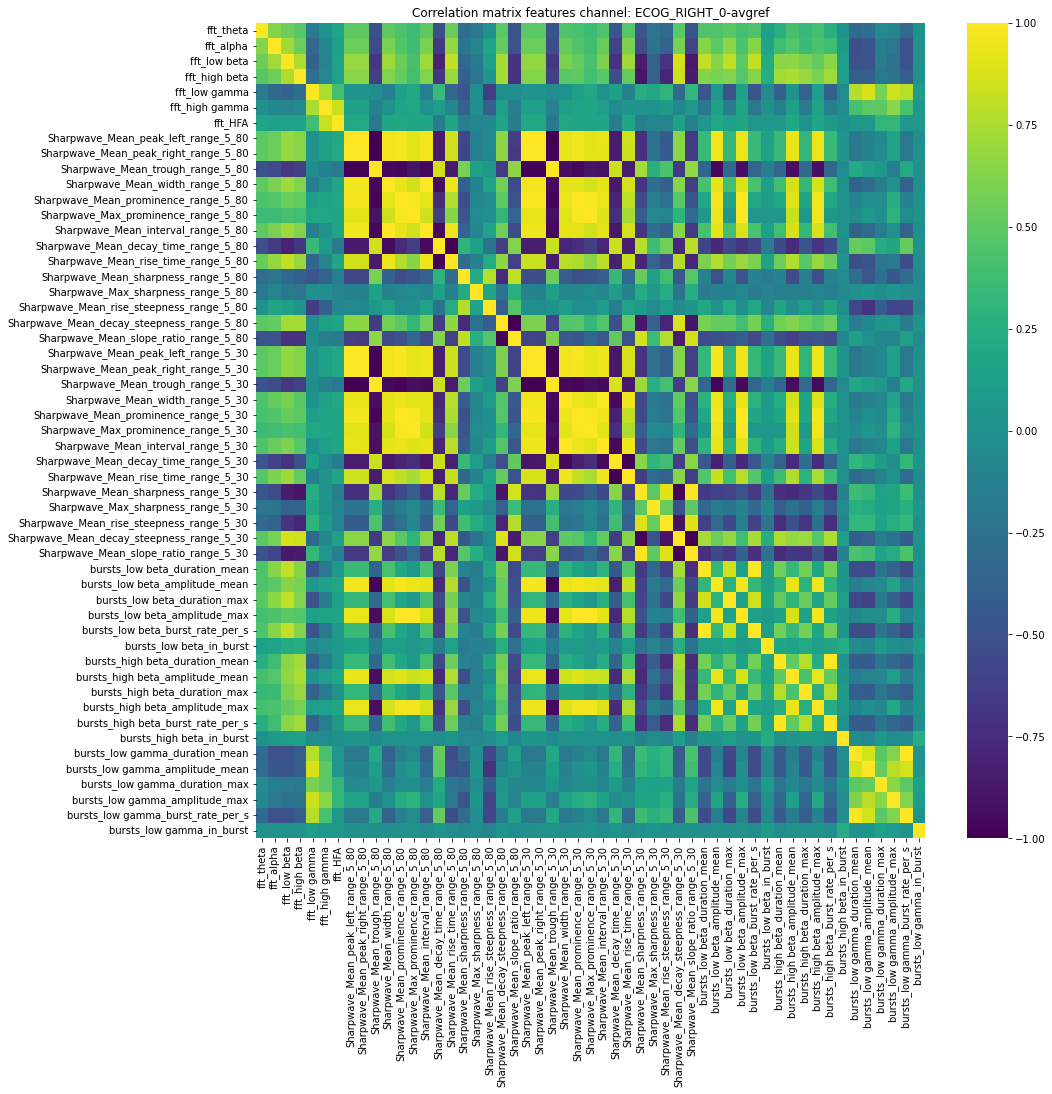

In [100]:
nm_plots.plot_corr_matrix(
    feature = feature_reader.feature_arr.filter(regex='ECOG_RIGHT_0'),
    ch_name= 'ECOG_RIGHT_0-avgref',
    feature_names=feature_reader.feature_arr.filter(regex='ECOG_RIGHT_0-avgref').columns,
    feature_file=feature_reader.feature_file,
    show_plot=True,
    figsize=(15,15),
)

### Decoding

The main focus of the py_neuromodulation pipeline is the feature estimation. Nevertheless, the user can also use the pipeline for Machine Learning decoding. It can be used for regression and classification problems, and also using unsupervised methods, such as PCA and CCA.

Here we show an example using the XGBOOST Classifier. The labels used come from the continuous grip force movement target, namedd "MOV_LEFT_CLEAN".

First we initialize the *nm_decode.Decoder* class, which the specified *validation method*, here being a simple 3-fold cross validation, the evaluation metric, the used machine learning model, and the used channels we want to evaluate performances for.

There are are many more implemented methods, but we will here limit here to the ones presented.

In [89]:
model = linear_model.LinearRegression()

feature_reader.decoder = nm_decode.Decoder(
    features=feature_reader.feature_arr,
    label=feature_reader.label,
    label_name=feature_reader.label_name,
    used_chs=feature_reader.used_chs,
    model=model,
    eval_method=metrics.r2_score,
    cv_method=model_selection.KFold(n_splits=3, shuffle=True),
)

In [90]:
performances = feature_reader.run_ML_model(
    estimate_channels=True,
    estimate_gridpoints=False,
    estimate_all_channels_combined=True,
    save_results=True,
)

model being saved to: C:\code\py_neuromodulation\examples\data\derivatives\sub-000_ses-right_task-force_run-3\sub-000_ses-right_task-force_run-3_LM_ML_RES.p


The performances is a dictionary, that we will now transform into a dataframe:

In [91]:
df_per = feature_reader.get_dataframe_performances(performances)

df_per

,performance_test,performance_train,sub,ch,ch_type
0,0.187735,0.613152,000,LFP_RIGHT_0-LFP_RIGHT_2,electrode ch
1,0.446129,0.668467,000,LFP_RIGHT_1-LFP_RIGHT_0,electrode ch
2,0.261070,0.608497,000,LFP_RIGHT_2-LFP_RIGHT_1,electrode ch
3,0.398090,0.713984,000,ECOG_RIGHT_0-avgref,electrode ch
4,0.480724,0.652312,000,ECOG_RIGHT_1-avgref,electrode ch
5,0.313613,0.638253,000,ECOG_RIGHT_2-avgref,electrode ch
6,0.157768,0.641390,000,ECOG_RIGHT_3-avgref,electrode ch
7,0.330807,0.588431,000,ECOG_RIGHT_4-avgref,electrode ch
8,0.202398,0.591196,000,ECOG_RIGHT_5-avgref,electrode ch
9,0.000000,1.000000,000,all_ch_combined,all ch combinded


Text(0.5, 1.0, 'Performance comparison Movement decoding')

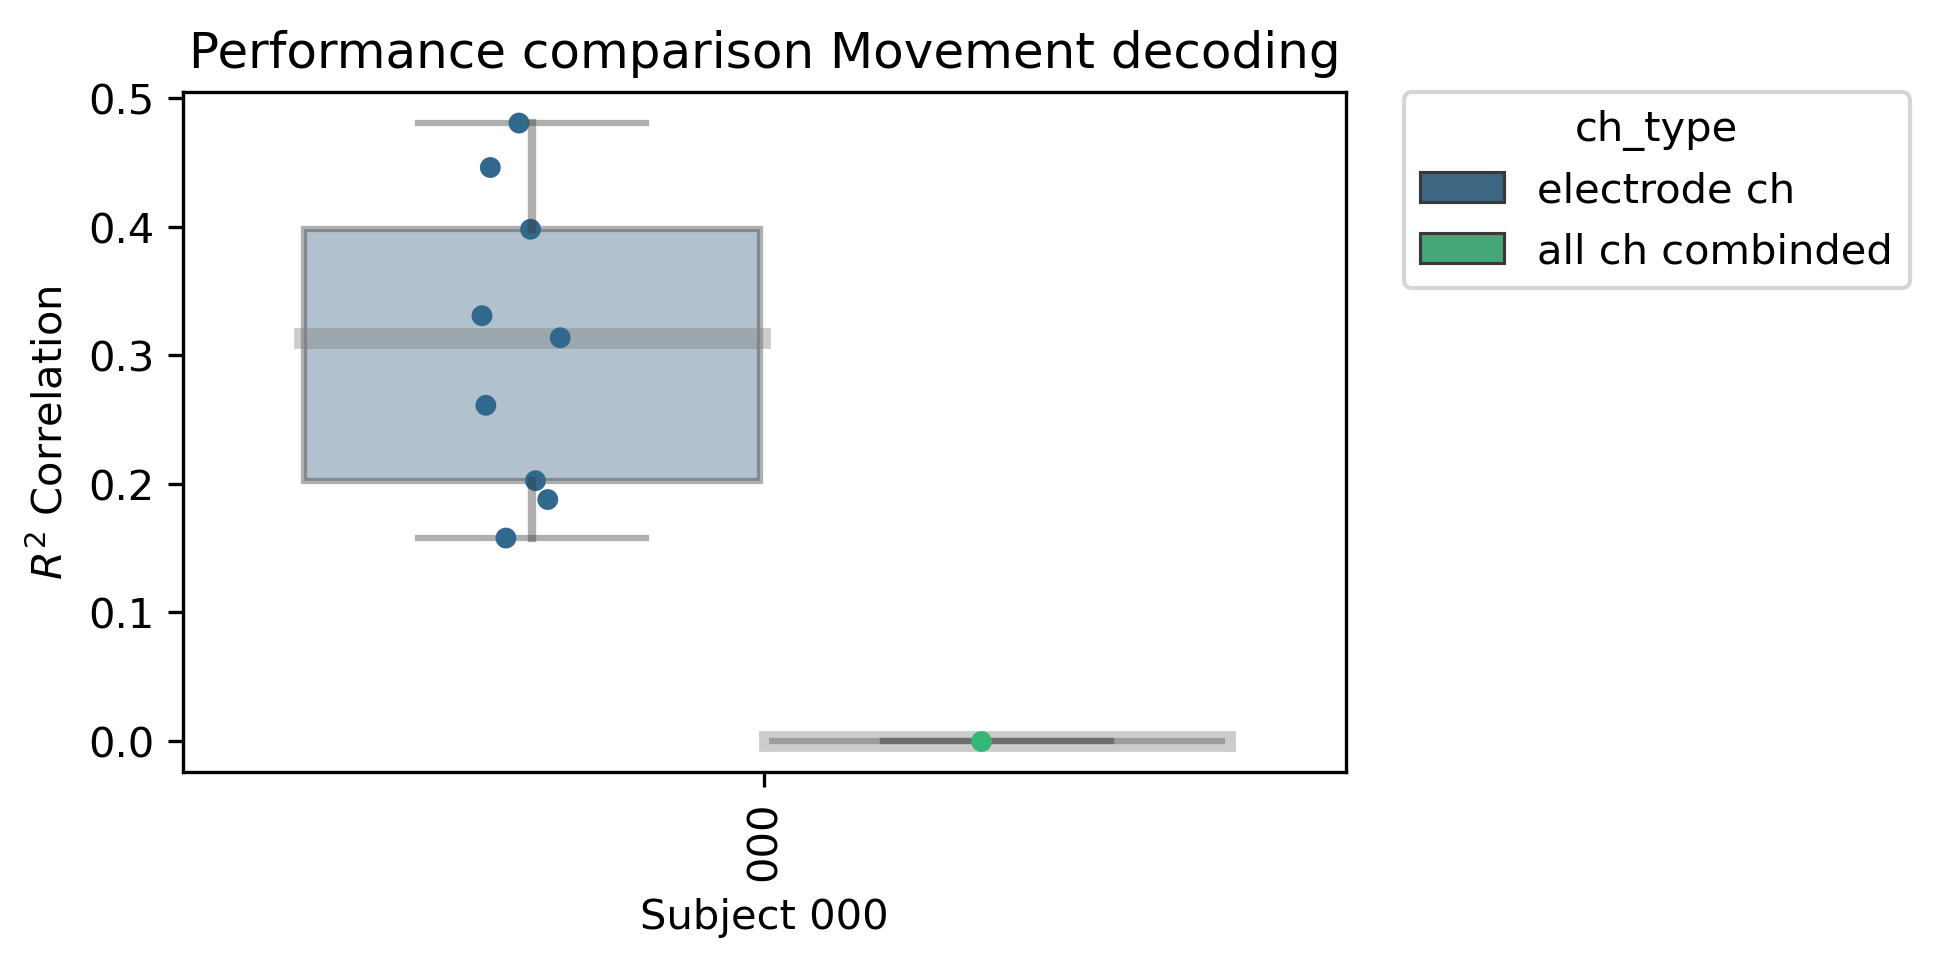

In [98]:
ax = nm_plots.plot_df_subjects(
    df_per, x_col="sub", y_col="performance_test", hue="ch_type",
    PATH_SAVE=os.path.join(PATH_OUT, RUN_NAME, RUN_NAME + "_decoding_performance.png")
)
ax.set_ylabel(r"$R^2$ Correlation")
ax.set_xlabel("Subject 000")
ax.set_title("Performance comparison Movement decoding")